Columns in dataset: ['Date_', 'Close_INFY.NS', 'Close_TCS.NS', 'High_INFY.NS', 'High_TCS.NS', 'Low_INFY.NS', 'Low_TCS.NS', 'Open_INFY.NS', 'Open_TCS.NS', 'Volume_INFY.NS', 'Volume_TCS.NS']
Detected stocks: ['INFY', 'TCS']

--- INFY Volume Prediction ---
Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
R2 Score: 0.17278724791307376
MSE: 73176144449793.14


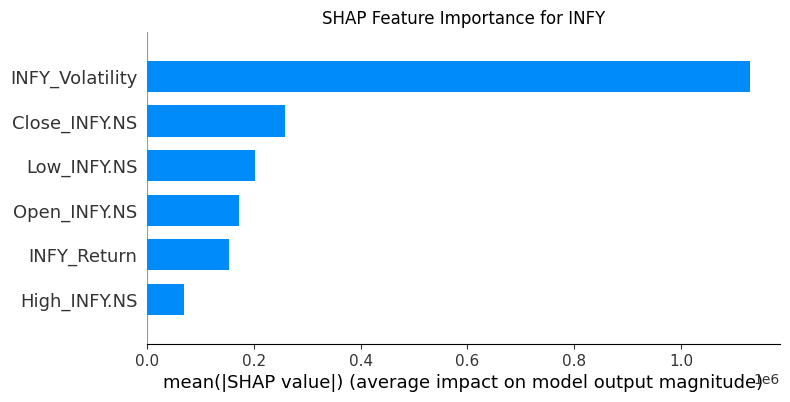


--- TCS Volume Prediction ---
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
R2 Score: 0.3896080233144028
MSE: 980123525508.35


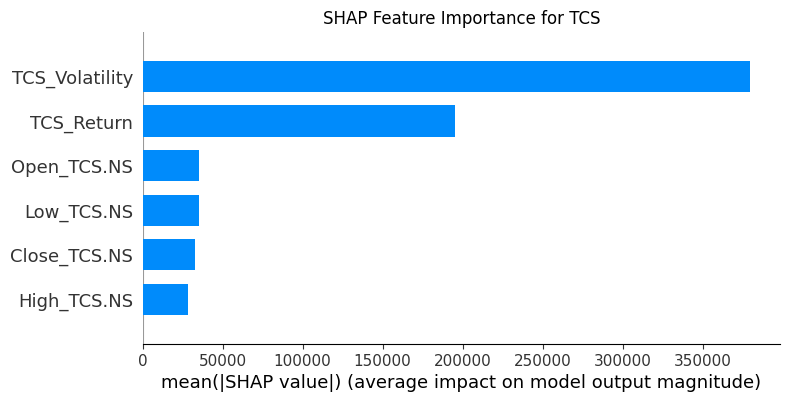

In [15]:
# Install required libraries
!pip install scikit-learn shap

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt

# -----------------------
# 1. Load dataset
# -----------------------
df = pd.read_csv("/content/clean_stock_data (1).csv")

# Check columns
print("Columns in dataset:", df.columns.tolist())

# -----------------------
# 2. Identify stocks dynamically
# -----------------------
# Identify stocks based on the pattern 'Close_STOCK.NS'
stocks = list(set([col.split("_")[1].split(".")[0] for col in df.columns if "Close_" in col]))
print("Detected stocks:", stocks)

# -----------------------
# 3. Feature Engineering
# -----------------------
for stock in stocks:
    try:
        # Daily Return
        df[f"{stock}_Return"] = df[f"Close_{stock}.NS"].pct_change()

        # Volatility
        df[f"{stock}_Volatility"] = (df[f"High_{stock}.NS"] - df[f"Low_{stock}.NS"]) / df[f"Close_{stock}.NS"]

        # Lagged Volume
        df[f"{stock}_Volume_lag1"] = df[f"Volume_{stock}.NS"].shift(1)
        df[f"{stock}_Volume_lag2"] = df[f"Volume_{stock}.NS"].shift(2)
        df[f"{stock}_Volume_lag3"] = df[f"Volume_{stock}.NS"].shift(3)

        # Moving Average Volume
        df[f"{stock}_Volume_MA5"] = df[f"Volume_{stock}.NS"].rolling(window=5).mean()
        df[f"{stock}_Volume_MA10"] = df[f"Volume_{stock}.NS"].rolling(window=10).mean()

    except KeyError as e:
        print(f"⚠️ Missing column for {stock}: {e}")

df = df.dropna()  # remove NaN rows created by feature engineering


# -----------------------
# 4. Train and Evaluate model for each stock
# -----------------------
for target_stock in stocks:
    print(f"\n--- {target_stock} Volume Prediction ---")

    # Build Features + Target
    features = [col for col in df.columns if target_stock in col and "Volume" not in col and "Date" not in col]
    X = df[features]
    y = df[f"Volume_{target_stock}.NS"]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # RandomForest + Hyperparameter Tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }

    rf = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    print("Best Parameters:", grid.best_params_)

    # Evaluate
    y_pred = best_model.predict(X_test)
    print("R2 Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))

    # SHAP Explainability
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)

    # Summary Plot
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance for {target_stock}")
    plt.show()

Columns: ['Headline', 'Market_Event', 'Date', 'risk_score', 'vader_sentiment', 'combined_score']
                                            Headline  \
0        Nikkei 225 index benefits from a weaker yen   
1  Government subsidy program gives a lift to the...   
2  New housing data release shows a slowdown in m...   
3  Massive stock buyback program announced by a c...   
4  Government spending bill is expected to stimul...   

                 Market_Event        Date  risk_score  vader_sentiment  \
0       Commodity Price Shock  2025-05-21         0.0          -0.0772   
1        Central Bank Meeting  2025-05-18         0.0           0.0000   
2  Consumer Confidence Report  2025-06-25         0.0           0.0000   
3       Commodity Price Shock  2025-07-21         0.0           0.0000   
4      Inflation Data Release  2025-07-23         0.0           0.2263   

   combined_score  
0        -0.03860  
1         0.00000  
2         0.00000  
3         0.00000  
4         0.11315  



/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


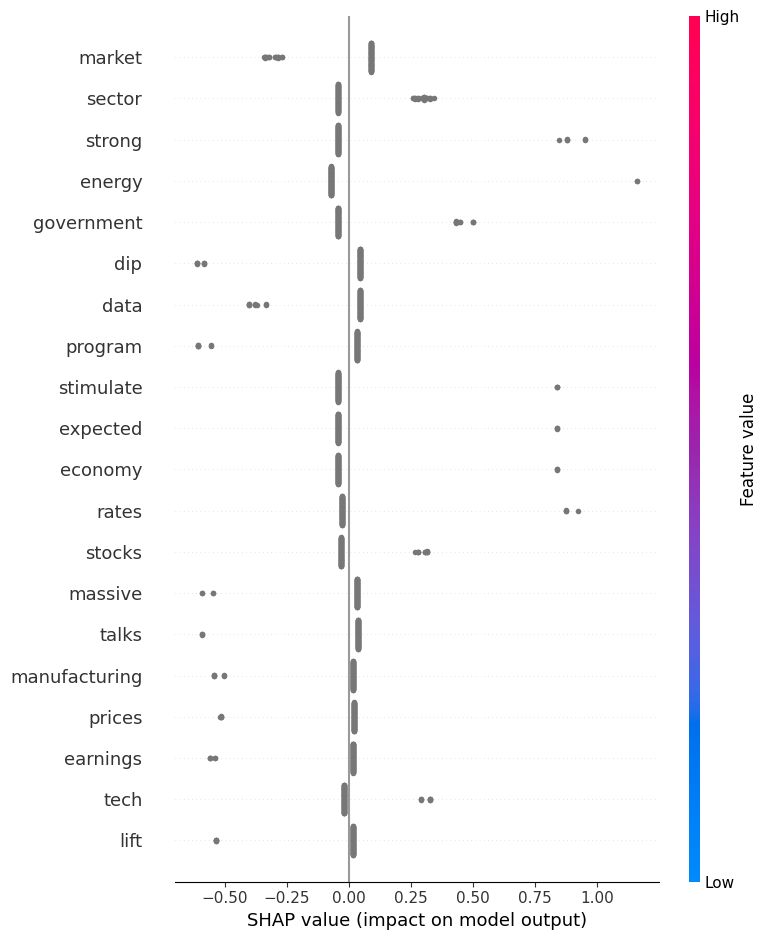

In [26]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import shap
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv("financial_news_processed (1).csv")
print("Columns:", df.columns.tolist())
print(df.head())

# 2. Choose text column
# Check if 'headline' or 'text' exists in your dataset
text_col = "Headline" if "Headline" in df.columns else "text" # Corrected 'headline' to 'Headline'

# 3. Define target column
# If dataset already has "sentiment", use that (e.g., Positive=1, Negative=0)
# Otherwise you will need to create labels manually
target_col = "combined_score"  # Changed to 'combined_score'
y = df[target_col]

# For classification with LogisticRegression, you'll likely need to discretize the target
# For example, you could classify based on whether combined_score is positive or negative
y_classified = (y > 0).astype(int) # Example: 1 for positive score, 0 otherwise

# 4. Preprocess text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X = vectorizer.fit_transform(df[text_col])

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_classified, test_size=0.2, random_state=42 # Use y_classified for training
)

# 6. Train Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# 7. Evaluate model
y_pred = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 8. Generate Credit Risk Score (0-100)
# This part might need adjustment depending on how you define risk based on sentiment
# For example, higher positive sentiment might mean lower risk.
# Let's assume a higher combined_score means lower risk for this example.
# We can use the probability of the positive class (sentiment > 0) as an indicator.
if 1 in model.classes_: # Check if the positive class (1) is in the model's classes
  risk_probs = model.predict_proba(X_test)[:, model.classes_.tolist().index(1)] # Probability of the positive class
  # Assuming higher probability of sentiment > 0 means lower risk
  credit_scores = ((1 - risk_probs) * 100).round(2) # Invert probability for risk score

  # Show sample predictions
  results = pd.DataFrame({
      "News": df[text_col].iloc[y_test.index],
      "Actual_Sentiment_Class": y_test,
      "Predicted_Sentiment_Class": y_pred,
      "Credit_Risk_Score (0-100)": credit_scores
  }).head(10)

  print("\nSample Credit Scores:\n", results)
else:
    print("\nModel did not predict the positive class (sentiment > 0). Cannot calculate risk scores based on positive class probability.")


# 9. Explainability with SHAP
# For classification, shap_values will be a list of arrays, one for each class.
# We usually explain the prediction of a specific class. Let's explain the positive class (sentiment > 0).
if 1 in model.classes_:
  class_to_explain = model.classes_.tolist().index(1) # Index of the positive class
  explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
  shap_values = explainer.shap_values(X_test[:100]) # Get SHAP values for all classes

  shap.summary_plot(shap_values, X_test[:100], feature_names=vectorizer.get_feature_names_out()) # Pass the full matrix
  plt.show()
else:
    print("\nModel did not predict the positive class (sentiment > 0). Cannot generate SHAP plot for the positive class.")